# Jina Workshop @ EuroPython: Building a Neural Image Search Engine

In this workshop we will build a neural search engine for images of Pokemons.

---

# TABLE OF CONTENTS

## 1. Document - the data
## 2. Flow - the pipeline
### 2.1 Indexing 
### 2.2 Searching
## 3. The Executor - the pipeline hops
### 3.1 Replacing
### 3.2 Creating
## 4. Optimizing the pipeline



---

## Pre-requisites

Skip this if you've already downloaded them.

### Download and Extract Data

For this example we're using Pokemon sprites from [veekun.com](https://veekun.com/dex/downloads). To download them run:

```sh
sh ./get_data.sh
```

### Download and Extract Pretrained Model

In this example we will first the use [BiT (Big Transfer) model](https://github.com/google-research/big_transfer), To download it:

```sh
sh ./download.sh
```

---

# The problem

We want to search Pokemon by pictures! For example 

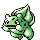

May return

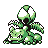 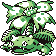

---

# Code

Automatically reload changed files when running code.

In [ ]:
%load_ext autoreload
%autoreload 2

Remove (some) warnings from TF and Torch

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Required imports

In [ ]:
import os
import sys
from shutil import rmtree
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

from jina import Flow, DocumentArray, Document

from jinahub.image.normalizer import ImageNormalizer
from jinahub.image.encoder.big_transfer import BigTransferEncoder
from jinahub.image.encoder.torch_encoder import ImageTorchEncoder

from components import MemMapIndexer

# Document

Here we prepare the data we want to search through.

Jina provides two abstractions:

- `Document`
- `DocumentArray`

Some configuration options.

- restrict the nr of docs we index
- the path to the images

In [ ]:
# TODO adapt nr of image. pre-index dataset before workshop
num_docs = int(os.environ.get('JINA_MAX_DOCS', 100))
image_src = sorted(list(glob('data/pokemon/main-sprites/red-blue/*.png')))

In [ ]:
for img_path in image_src[:5]:
    img = Image.open(img_path)
    imshow(img)
    plt.title(img_path)
    plt.show()

In [ ]:
def get_docs(image_src, num_docs):
    docs = DocumentArray()

    for file in image_src:
        # Uniform Resource Identifier
        doc = Document(uri=file)
        doc.convert_image_uri_to_blob()
        doc.tags['filename'] = file
        docs.append(doc)
        if len(docs) == num_docs:
            break
            
    return docs

In [ ]:
docs = get_docs(image_src, num_docs)

In [ ]:
len(docs)

# Flows

Environment variables

- workspace (folder where the encoded data will be stored)
- port we will listen on

In [ ]:
workspace = './workspace'
os.environ['JINA_WORKSPACE'] = workspace
os.environ['JINA_PORT'] = os.environ.get('JINA_PORT', str(45678))

We need to make sure to not index on top of an existing workspace. 

This can cause problems if you are using different configuration options between the two runs.

## Index

This is the Flow we use to perform operations on our data.

In [ ]:
f = Flow.load_config('flows/flow-torch-logger.yml')

In [ ]:
if os.path.exists(workspace):
    print(f'Workspace at {workspace} exists. Will delete')
    rmtree(workspace)

We can plot it.

In [ ]:
f.plot('index.png')

The Flow is the main pipeline in Jina. It describes the way data should be loaded, processed, stored etc. within the system. 

It is made up of components (called Executors), which are the ones doing the specific task.

Ex. we have a crafter Executor, which preprocesses the data; an Encoder Executor, which loads the model and *encodes* that data;  Indexer Executor, which stores and retrieves the data etc.

The Flow is a context manager (like a file handler). Within the context, it starts all the Executors within their processes / threads.

We load data into the pipeline from the directory we provided above. 

`request_size` dictates how many images should be sent in one request (~batching).

In [ ]:
with f:
    f.post(
        on='/index',
        inputs=docs,
        request_size=64,
    )

# Questions?

---

## Searching

We load the first image in the dataset

In [ ]:
red_green = sorted(list(glob('data/pokemon/main-sprites/red-green/*.png', recursive=False)))

In [ ]:
search_image = red_green[0]

# Let's plot the image

pil_im = Image.open(search_image)
imshow(pil_im)

We build a Document with that image

In [ ]:
query_docs = get_docs(red_green, 1)

Let's examine the tags

In [ ]:
query_docs[0].tags

Tags can store any relevant meta-data about the Document (ex. price, URL, category, etc.)

In [ ]:
# searching
with f:
    return_docs = f.post(
        on='/search',
        inputs=query_docs,
        parameters={'top_k': 5},
        return_results=True
    )

Retrieving tags (image path)

**Results**

Top match should be the corresponding Pokemon in the other edition.

In [ ]:
return_docs[0].docs[0].matches[0].tags['filename'], return_docs[0].docs[0].tags['filename']

Reconstructing the original image from the Document content

In [ ]:
for match in return_docs[0].docs[0].matches:
    filename = match.tags['filename']
    img = Image.open(filename)
    imshow(img)
    plt.title(match.tags['filename'])
    plt.show()

# Questions?

---

# Advanced Topics


**NOTE**: After configuring these, you will need to re-index your data and search again. 

## 1. Changing Encoders

We can switch the `Encoder` easily.

This is the component that is the actual **model**. This encodes the images into a vector space upon which you can perform cosine similarity (or other linear algebra operations).


`flows/flow.yml`:

```yaml
...
  - name: encoder
    timeout_ready: 600000
    uses:
        jtype: ImageTorchEncoder
...
```

We also need to make sure the class is discoverable in the current runtime:

By default it uses `resnet18`. We can change this with

```yaml
...
  - name: encoder
    timeout_ready: 600000
    uses:
        jtype: ImageTorchEncoder
        with:
            model_name: resnet101
...
```


In [ ]:
from jinahub.image.encoder.torch_encoder import ImageTorchEncoder

Now we re-run the cells above with the new Flow. Make sure to **delete the workspace**.

**RESULTS** Notice that TorchEncoder returns the most similar postion.

# Questions?

---

## 2. Your own custom Executor

Next let's delve one level deeper into Jina.

So far we have looked at the Flow (top level) and the Document (one element of data).

The intermediate level is the Executor (which is a component in the pipeline of the Flow).

Let's create an Executor which "logs" the query results.

OPTIONAL It's parallel.

OPTIONAL It's hanging.

In [ ]:
from components import RequestLogger

# Questions?

---

## 3. Optimization

In every Flow that is build with Jina, there are quite some parameters to set.
For example, if you use a pre-trained model for encoding, there is no obvious best choice for a given dataset.
Jina allows you to try out a lot of different parameters automatically in order to get the best results.

Therefor, you need to provide Jina some sort of evaluation metric.
In the pokemon dataset, there are two edition with the same pokemon, but different images: `red-blue` and `red-green`.

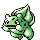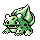

Thus, we will setup the following evaluation metric:
Index one edition and search with the other edition.
We have a success, if the right pokemon is at the first place in the search results.

We need to do the following steps:

- A) build an `index` and a `search` Flow, which are repeaditly runnable
- B) use the `red-blue` dataset for `index` and the `red-green` for `search`
- C) implement an `EvaluationCallback` which will calculate, if the right pokemon is in the first place
- D) set the needed `OptimizationParameter` via a `parameter.yml` file
- E) setup the optimization process itself

**NOTE**: Under the hood, we use [optuna](https://optuna.readthedocs.io/en/stable/) for hyperparameter optimization.

### Do the imports

In [ ]:
from glob import iglob
from jina import Document
from jina.optimizers.flow_runner import SingleFlowRunner, MultiFlowRunner
from jina.optimizers import FlowOptimizer, EvaluationCallback

### A) & B)

Jina provides the 
- `SingleFlowRunner` for making a Flow repeaditly runnable and the 
- `MultiFlowRunner` to chain multiple `SingleFlowRunner` for the `FlowOptimizer`

For setup you need:
- `flow_yaml`: the definition of a Flow
- `documents`: the Documents, which are send to the Flow in each optimization step
- `execution_method`: tell the Flow, whether `index` or `search` should be used

Beware, that we introduce `JINA_MODEL_NAME_VAR: ${{JINA_MODEL_NAME}}` in the two new Flow definition.
This variable will allow us to change the model in the Flow in each optimization step.

In [ ]:
def get_input_iterator(edition, full_document):
    image_src = f'data/pokemon/main-sprites/{edition}/*.png'
    for filename in iglob(image_src, recursive=True):
        doc = Document(uri=filename)
        doc.convert_image_uri_to_blob()

        doc.blob = doc.blob.astype(np.uint8)
        doc.tags['filename'] = filename
        yield doc

def get_flows():
    index_flow = SingleFlowRunner(
        flow_yaml='flows/flow_opt.yml',
        documents=get_input_iterator('red-blue', True),
        request_size=64,
        execution_endpoint='/index',
        overwrite_workspace=True
    )

    search_flow = SingleFlowRunner(
        flow_yaml='flows/flow_opt.yml',
        documents=get_input_iterator('red-green', False),
        request_size=64,
        execution_endpoint='/search'
    )

    multi_flow = MultiFlowRunner([index_flow, search_flow])
    return multi_flow


### C) implement an `EvaluationCallback` which will calculate, if the right pokemon is in the first place

Since the files are named the same for both editions, we use the filename as an identifier, whether we found the right pokemon.
The `PokemonCallback` checks for each Document, whether the correct result is in the first position.

In [ ]:
def get_id(filename):
    return filename.split('/')[-1].split('.')[0]

class PokemonCallback(EvaluationCallback):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._eval_name = "pokedex_eval"

    def get_empty_copy(self):
        return PokemonCallback(self._eval_name)
    
    def __call__(self, response):
        self._n_docs += len(response.data.docs)
        for doc in response.data.docs:
            if doc.matches:
                document_id = get_id(str(doc.tags.fields['filename']))
                first_match_id = get_id(str(doc.matches[0].tags.fields['filename']))
                if document_id == first_match_id:
                    self._evaluation_values[self._eval_name].append(1)
                else:
                    self._evaluation_values[self._eval_name].append(0)
                    

### D) set the needed `OptimizationParameter` via a `parameter.yml` file

We defined in the `parameter_few.yml` the models, that the optimizer should try out.
For demonstation purpose, we just added three models, in order to make the optimizer run rather short.
If you want to try mode models, please use the `parameter.yml` file and increase `n_trials` parameter in the `FlowOptimizer` below

### E) setup the optimization process itself

Finally, we build the `FlowOptimizer` object.
It needs:
- `flow_runner`: the repeaditly runnable Flow object
- `parameter_yaml`: the parameters which the optimizer can change
- `evaluation_callback`: our previously defined evaluation function
- `workspace_base_dir`: A directory for temporary data
- `n_trials`: The amount of optimization steps, that should be performed
- `sampler`: the way, the `FlowOptimizer` should sample new values in each step. For more info please look at the [optuna docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.RandomSampler.html#optuna.samplers.RandomSampler).

In [ ]:
def optimize(flows):
    optimizer = FlowOptimizer(
        flow_runner=flows,
        parameter_yaml='optimize/parameters_few.yml',
        evaluation_callback=PokemonCallback(eval_name='correct'),
        workspace_base_dir='workspace',
        n_trials=3,
        sampler='RandomSampler',
        # to guarantee reproducibility in the sampling
        seed=1
    )
    result = optimizer.optimize_flow()
    result.save_parameters('optimize/best_config.yml')

In [ ]:
flows = get_flows()
optimize(flows)

We can now check `optimize/best_config.yml` to see our best configuration.